In [1]:
import os
import rosbag
from data_loader.ros_msg.pointcloud import PointCloud
from data_loader.ros_msg.image import Image
from data_loader.ros_msg.odometry import Odometry
from data_loader.calib.intrinsic_extrinsic_loader import IntrinsicExtrinsicLoader
from data_loader.file_loader import FileLoader
from data_loader.file_writer import FileWriter
from tools.utils import *

platform = 'vehicle'
sequence_name = 'vehicle_campus00'
algorithm = 'r3live'

Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/ouster00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/event_cam00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/event_cam01.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/frame_cam00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/frame_cam01.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibra

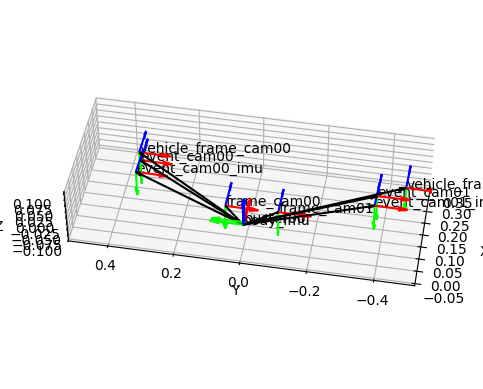

Finish loading parameters


0

In [2]:
##### Set up the output data path
dataset_path = '/Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined'
calib_path = os.path.join(dataset_path, '../../calibration_files/20230618_calib/calib')
kitti_path = os.path.join(dataset_path, sequence_name, 'kitti')

##### Set up the message topic list for different platforms
if platform == 'handheld':
  from cfg.dataset.cfg_handheld import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_handheld import dataset_rostopic_msg_frameid_dict
elif platform == 'ugv':
  from cfg.dataset.cfg_ugv import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_ugv import dataset_rostopic_msg_frameid_dict
elif platform == 'legged_robot':
  from cfg.dataset.cfg_legged_robot import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_legged_robot import dataset_rostopic_msg_frameid_dict
elif platform =='vehicle':
  from cfg.dataset.cfg_vehicle import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_vehicle import dataset_rostopic_msg_frameid_dict

if algorithm == 'r3live':
  from cfg.algorithm.cfg_r3live import algorithm_rostopic_msg_frameid_dict

##### Set up the sensor configuration
int_ext_loader = IntrinsicExtrinsicLoader(is_print=False)
int_ext_loader.load_calibration(calib_path=calib_path, sensor_frameid_dict=dataset_sensor_frameid_dict)
int_ext_loader.tf_graph.visualize_graph()
print('Finish loading parameters')

data_path = os.path.join(dataset_path, sequence_name, 'raw_data')
alg_result_path = os.path.join(dataset_path, sequence_name, 'algorithm_result')
file_loader = FileLoader()
file_writer = FileWriter()

os.system('mkdir -p '+ os.path.join(kitti_path, 'calibration'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'ouster00_undistort/points/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'ouster00/points/data'))
if platform == 'vehicle':
  os.system('mkdir -p '+ os.path.join(kitti_path, 'vehicle_frame_cam00/image/data'))
  os.system('mkdir -p '+ os.path.join(kitti_path, 'vehicle_frame_cam01/image/data'))
else:
  os.system('mkdir -p '+ os.path.join(kitti_path, 'frame_cam00/image/data'))
  os.system('mkdir -p '+ os.path.join(kitti_path, 'frame_cam01/image/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'event_cam00/image/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'event_cam01/image/data'))

In [3]:
##### Load timestamp from alg_result
# Ouster
if 'ouster_points' in dataset_rostopic_msg_frameid_dict.keys():
  ouster_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'ouster00/points/timestamps.txt')) 
  print('Loading ouster_timestamps: {}'.format(len(ouster_timestamps)))

##### Load timestamp from raw_data
# Ouster_undistort at the ouster00 frame
t_add = 0.08 # the timestamp of the ouster00_undistorted is at the time of the last point approximate to 0.08s
if 'ouster_points_undistorted' in algorithm_rostopic_msg_frameid_dict.keys():
  ouster_un_timestamps = file_loader.load_timestamp(os.path.join(alg_result_path, 'ouster00_undistort/points/timestamps.txt'))
  print('Loading ouster_un_timestamps: {}'.format(len(ouster_un_timestamps)))

# Frame_camera
if platform =='vehicle':
  if 'vehicle_frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam00/image/timestamps.txt'))
    print('Loading vehicle_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'vehicle_frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam01/image/timestamps.txt'))
    print('Loading vehicle_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
else:
  if 'frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam00/image/timestamps.txt'))
    print('Loading frame_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam01/image/timestamps.txt'))
    print('Loading frame_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
    
# Event_camera
if 'event_left_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam00/image/timestamps.txt'))
  print('Loading event_left_timestamps: {}'.format(len(event_left_image_timestamps)))
if 'event_right_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam01/image/timestamps.txt'))
  print('Loading event_right_timestamps: {}'.format(len(event_right_image_timestamps)))

##### Match synchronized timestamps
matched_id_ouster_sensors = []
th_ouster_ousterun = 0.02
th_ouster_fc, th_fl_fr = 0.05, 0.03
th_ouster_ec, th_el_er = 0.05, 0.05
for id, time in enumerate(ouster_timestamps):
  ouster_un_time, ouster_id = find_closest_element_sorted(ouster_un_timestamps, time + t_add)
  fl_time, fl_id = find_closest_element_sorted(frame_left_image_timestamps, time)
  fr_time, fr_id = find_closest_element_sorted(frame_right_image_timestamps, time)
  el_time, el_id = find_closest_element_sorted(event_left_image_timestamps, time)
  er_time, er_id = find_closest_element_sorted(event_right_image_timestamps, time)

  # Not include event cameras
  # if abs(time - ouster_un_time) < 0.1:
  #   if abs(time - fl_time) < 0.03 and abs(time - fr_time) < 0.03 and abs(fl_time - fr_time) < 0.03:
  #     matched_id_ouster_sensors.append([id, ouster_id, fl_id, fr_id])

  # Include event cameras
  if abs(time + t_add - ouster_un_time) < th_ouster_ousterun:
    if abs(time - fl_time) < th_ouster_fc and abs(time - fr_time) < th_ouster_fc and abs(fl_time - fr_time) < th_fl_fr:
      if abs(time - el_time) < th_ouster_fc and abs(time - er_time) < th_ouster_fc and abs(el_time - er_time) < th_el_er:
        matched_id_ouster_sensors.append([id, ouster_id, fl_id, fr_id, el_id, er_id])
  
print('Length of matched id (ouster_un - sensors): {}'.format(len(matched_id_ouster_sensors)))

Loading ouster_timestamps: 6111
Loading ouster_un_timestamps: 5606
Loading vehicle_left_timestamps: 12220
Loading vehicle_right_timestamps: 12220
Loading event_left_timestamps: 12220
Loading event_right_timestamps: 12220
Length of matched id (ouster_un - sensors): 5578


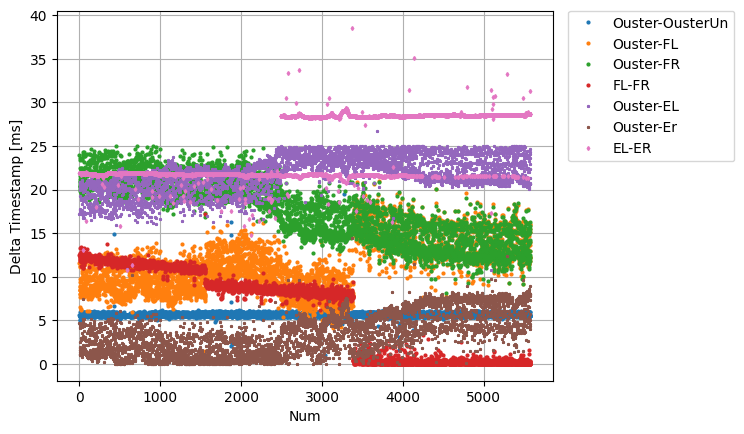

In [4]:
##### Analyze matched timestamps
if len(matched_id_ouster_sensors) > 0:
  import matplotlib.pyplot as plt
  num = [i for i in range(0, len(matched_id_ouster_sensors))]
  
  dt_ouster_ousterun = [1e3 * abs(ouster_timestamps[mid[0]] + t_add - ouster_un_timestamps[mid[1]]) for mid in matched_id_ouster_sensors]
  plt.plot(num, dt_ouster_ousterun, label='Ouster-OusterUn', marker='o', markersize=2, linestyle='none')

  dt_ouster_fl = [1e3 * abs(ouster_timestamps[mid[0]] - frame_left_image_timestamps[mid[2]]) for mid in matched_id_ouster_sensors]
  plt.plot(num, dt_ouster_fl, label='Ouster-FL', marker='o', markersize=2, linestyle='none')
  dt_ouster_fr = [1e3 * abs(ouster_timestamps[mid[0]] - frame_right_image_timestamps[mid[3]]) for mid in matched_id_ouster_sensors]
  plt.plot(num, dt_ouster_fr, label='Ouster-FR', marker='o', markersize=2, linestyle='none')
  dt_fl_fr = [1e3 * abs(frame_left_image_timestamps[mid[2]] - frame_right_image_timestamps[mid[3]]) for mid in matched_id_ouster_sensors]
  plt.plot(num, dt_fl_fr, label='FL-FR', marker='o', markersize=2, linestyle='none')
  
  if len(matched_id_ouster_sensors[0]) == 6:
    dt_ouster_el = [1e3 * abs(ouster_timestamps[mid[0]] - event_left_image_timestamps[mid[4]]) for mid in matched_id_ouster_sensors]
    plt.plot(num, dt_ouster_el, label='Ouster-EL', marker='*', markersize=2, linestyle='none')
    dt_ouster_er = [1e3 * abs(ouster_timestamps[mid[0]] - event_right_image_timestamps[mid[5]]) for mid in matched_id_ouster_sensors]
    plt.plot(num, dt_ouster_er, label='Ouster-Er', marker='*', markersize=2, linestyle='none')
    dt_el_er = [1e3 * abs(event_left_image_timestamps[mid[4]] - event_right_image_timestamps[mid[5]]) for mid in matched_id_ouster_sensors]
    plt.plot(num, dt_el_er, label='EL-ER', marker='d', markersize=2, linestyle='none')

  plt.xlabel('Num') 
  plt.ylabel('Delta Timestamp [ms]')
  plt.legend(loc='upper right', bbox_to_anchor=(1.38, 1.02))
  plt.grid(True)  
  plt.show()

  # for mid in matched_id_ouster_sensors[:5]:
  #   print(ouster_timestamps[mid[0]], ouster_un_timestamps[mid[1]], 1e3 * abs(ouster_timestamps[mid[0]] - ouster_un_timestamps[mid[1]]))

In [45]:
def rewrite_undistort_image(old_path, new_path, camera):
  import cv2
  img = cv2.imread(old_path)
  undistorted_img = camera.undistort(img)
  cv2.imwrite(new_path, undistorted_img)

# Save timestamps
select_time = [ouster_timestamps[mid[0]] for mid in matched_id_ouster_sensors]
file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'ouster00/points/timestamps.txt'))
select_time = [ouster_un_timestamps[mid[1]] for mid in matched_id_ouster_sensors]
file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'ouster00_undistort/points/timestamps.txt'))
if platform =='vehicle':
  select_time = [frame_left_image_timestamps[mid[2]] for mid in matched_id_ouster_sensors]
  file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'vehicle_frame_cam00/image/timestamps.txt'))
  select_time = [frame_right_image_timestamps[mid[3]] for mid in matched_id_ouster_sensors]
  file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'vehicle_frame_cam01/image/timestamps.txt'))
else:
  select_time = [frame_left_image_timestamps[mid[2]] for mid in matched_id_ouster_sensors]
  file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'frame_cam00/image/timestamps.txt'))
  select_time = [frame_right_image_timestamps[mid[3]] for mid in matched_id_ouster_sensors]
  file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'frame_cam01/image/timestamps.txt'))
select_time = [event_left_image_timestamps[mid[2]] for mid in matched_id_ouster_sensors]
file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'event_cam00/image/timestamps.txt'))
select_time = [event_right_image_timestamps[mid[3]] for mid in matched_id_ouster_sensors]
file_writer.write_timestamp(select_time, os.path.join(kitti_path, 'event_cam01/image/timestamps.txt'))

# Copy and paste data
for frame_id, mid in enumerate(matched_id_ouster_sensors):
  os_data_path = os.path.join(data_path, 'ouster00/points/data', '{:06d}.pcd'.format(mid[0]))
  new_data_path = os.path.join(kitti_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_data_path, new_data_path))

  os_un_data_path = os.path.join(alg_result_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(mid[1]))
  new_data_path = os.path.join(kitti_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_un_data_path, new_data_path))

  if platform == 'vehicle':
    fl_data_path = os.path.join(data_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(mid[2]))
    new_data_path = os.path.join(kitti_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
    rewrite_undistort_image(fl_data_path, new_data_path, camera)
    
    fr_data_path = os.path.join(data_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fr_data_path, new_data_path))
    camera = int_ext_loader.sensor_collection['vehicle_frame_right_camera']
    rewrite_undistort_image(fr_data_path, new_data_path, camera)
  else:
    fl_data_path = os.path.join(data_path, 'frame_cam00/image/data', '{:06d}.png'.format(mid[2]))
    new_data_path = os.path.join(kitti_path, 'frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fl_data_path, new_data_path))
    camera = int_ext_loader.sensor_collection['frame_left_camera']
    rewrite_undistort_image(fl_data_path, new_data_path, camera)

    fr_data_path = os.path.join(data_path, 'frame_cam01/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti_path, 'frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['frame_right_camera']
    rewrite_undistort_image(fr_data_path, new_data_path, camera)

  el_data_path = os.path.join(data_path, 'event_cam00/image/data', '{:06d}.png'.format(mid[4]))
  new_data_path = os.path.join(kitti_path, 'event_cam00/image/data', '{:06d}.png'.format(frame_id))
  camera = int_ext_loader.sensor_collection['event_left_camera']
  rewrite_undistort_image(el_data_path, new_data_path, camera)

  er_data_path = os.path.join(data_path, 'event_cam01/image/data', '{:06d}.png'.format(mid[5]))
  new_data_path = os.path.join(kitti_path, 'event_cam01/image/data', '{:06d}.png'.format(frame_id))
  os.system('cp {} {}'.format(er_data_path, new_data_path))
  camera = int_ext_loader.sensor_collection['event_right_camera']
  rewrite_undistort_image(er_data_path, new_data_path, camera)

print('Finish constructing kitti-type dataset')

Finish constructing kitti-type dataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


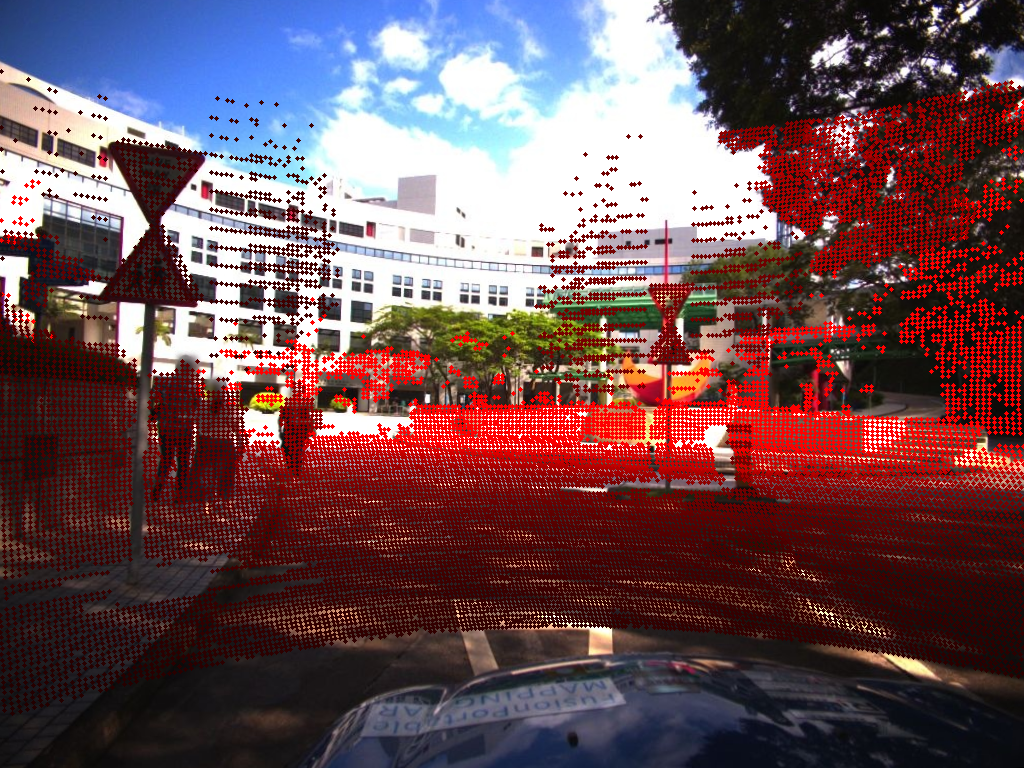

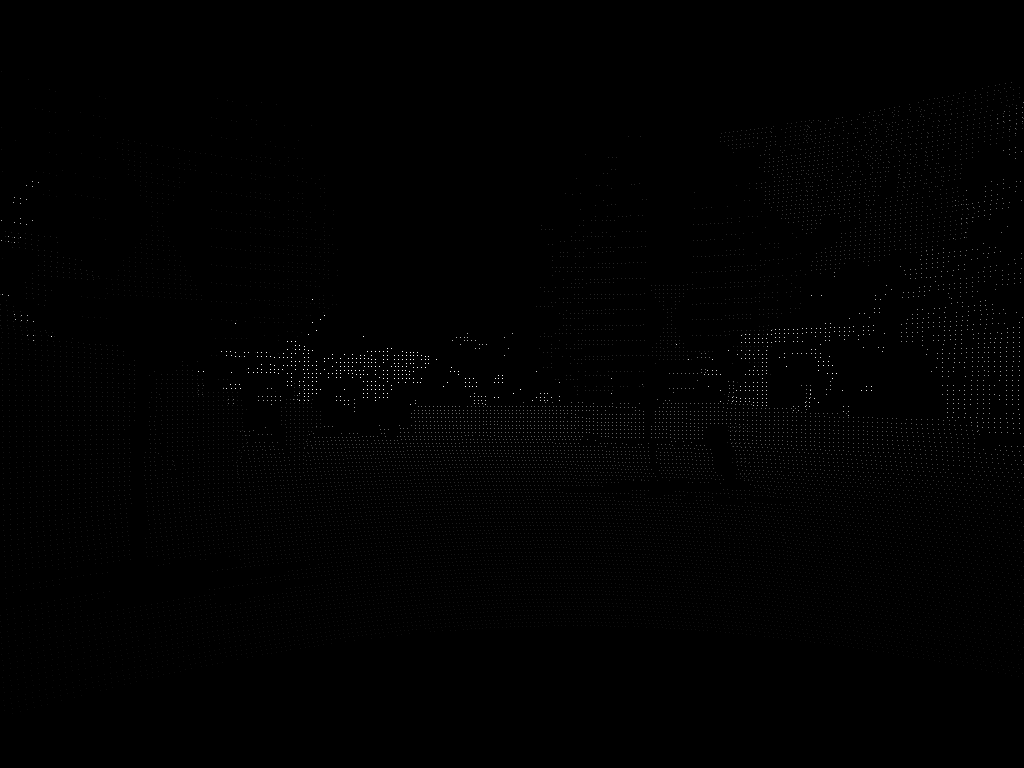

In [5]:
import cv2
import open3d
from PIL import Image
from IPython.display import display

frame_id = 500

##### Load point cloud and image
pcd_path = os.path.join(kitti_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
xyz_points = np.asarray(pcd.points)

if platform == 'vehicle':
  img_path = os.path.join(kitti_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
  img = cv2.imread(img_path)
  camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
else:
  img_path = os.path.join(kitti_path, 'frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
  img = cv2.imread(img_path)
  camera = int_ext_loader.sensor_collection['frame_left_camera']

##### Load extrinsics from the tf_graph
T_cam_lidar = int_ext_loader.tf_graph.get_relative_transform(camera.frame_id, 'ouster00')
xyz_points_cam = np.matmul(T_cam_lidar[:3, :3], xyz_points.T).T + T_cam_lidar[:3, 3].T

##### Project point cloud onto the camera frame
for p_C in xyz_points_cam:
  flag, u_C = camera.project(p_C)
  if flag:
    color = (0, 0, int(min(p_C[2] / 20.0, 1.0) * 255))
    cv2.circle(img, (int(u_C[0]), int(u_C[1])), radius=2, color=color, thickness=-1)
img_pillow = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
display(img_pillow)

##### Project point cloud onto the depth camera frame
depth_img = np.zeros((camera.height, camera.width), dtype=np.uint32)
for p_C in xyz_points_cam:
  flag, u_C = camera.project(p_C)
  if flag:
    depth_img[int(u_C[1])][int(u_C[0])] = np.uint32(p_C[2] * 1000)
img_pillow = Image.fromarray(depth_img)
display(img_pillow)

In [7]:
# Save calibration files according to KITTI format
calib_file_path = os.path.join(kitti_path, 'calibration', 'calib_cam_to_pose.txt')
with open(calib_file_path, 'w') as file:
  if platform == 'vehicle':
    T = int_ext_loader.tf_graph.get_relative_transform('vehicle_frame_cam00', 'body_imu')[:3, :4]
    str = 'image_00: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
    file.write(str)
    T = int_ext_loader.tf_graph.get_relative_transform('vehicle_frame_cam01', 'body_imu')[:3, :4]
    str = 'image_01: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
    file.write(str)
  else:
    T = int_ext_loader.tf_graph.get_relative_transform('frame_cam00', 'body_imu')[:3, :4]
    str = 'image_00: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
    file.write(str)
    T = int_ext_loader.tf_graph.get_relative_transform('frame_cam01', 'body_imu')[:3, :4]
    str = 'image_01: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
    file.write(str)

  T = int_ext_loader.tf_graph.get_relative_transform('event_cam00', 'body_imu')[:3, :4]
  str = 'image_02: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
  file.write(str)

  T = int_ext_loader.tf_graph.get_relative_transform('event_cam01', 'body_imu')[:3, :4]
  str = 'image_03: ' + ' '.join('{:9f}'.format(x) for x in T.flatten()) + '\n'
  file.write(str)

calib_file_path = os.path.join(kitti_path, 'calibration', 'perspective.txt')
with open(calib_file_path, 'w') as file:
  if platform == 'vehicle':
    camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
    T = int_ext_loader.tf_graph.get_relative_transform(camera.frame_id, 'vehicle_frame_left_camera')
    file.write('calib_time: {camera.dataset_name}\n')
    file.write('corner_dist: 0.1\n')
    file.write('S_00: {} {}\n'.format(camera.width, camera.height))
    file.write('K_00: {} {} {} {} {} {} {} {} {}\n'.format(
      camera.K[0][0], camera.K[0][1], camera.K[0][2], 
      camera.K[1][0], camera.K[1][1], camera.K[1][2],
      camera.K[2][0], camera.K[2][1], camera.K[2][2]))
    # file.write('D_00: {}.format(camera.D[0]) {}.format(camera.D[1]) {}.format(camera.D[2]) {}.format(camera.D[3]) {}.format(camera.D[4]}\n')
    # file.write('R_00: {}.format(T[0][0]) {}.format(T[0][1]) {}.format(T[0][2]) \
    #                   {}.format(T[1][0]) {}.format(T[1][1]) {}.format(T[1][2]) \
    #                   {}.format(T[2][0]) {}.format(T[2][1]) {}.format(T[2][2])\n')
    # file.write('T_00: {}.format(T[0][3]) {}.format(T[1][3]) {}.format(T[2][3])\n')
    # file.write('S_rect_00: {}.format(camera.width) {}.format(camera.height}\n')
    # file.write('R_rect_00: {}.format(T[0][0]) {}.format(T[0][1]) {}.format(T[0][2]) \
    #                        {}.format(T[1][0]) {}.format(T[1][1]) {}.format(T[1][2]) \
    #                        {}.format(T[2][0]) {}.format(T[2][1]) {}.format(T[2][2])\n')
    # file.write('P_rect_00: {}.format(camera.K[0][0]) {}.format(camera.K[0][1]) {}.format(camera.K[0][2]) \
    #                        {}.format(camera.K[1][0]) {}.format(camera.K[1][1]) {}.format(camera.K[1][2]) \
    #                        {}.format(camera.K[2][0]) {}.format(camera.K[2][1]) {}.format(camera.K[2][2])\n')    


std::vector<Eigen::Vector3d> with 96104 elements.
Use numpy.asarray() to access data.
std::vector<Eigen::Vector3d> with 131072 elements.
Use numpy.asarray() to access data.


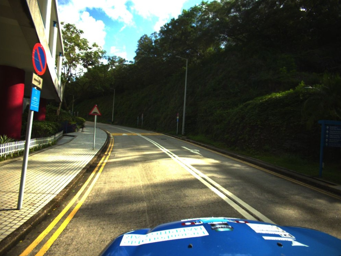

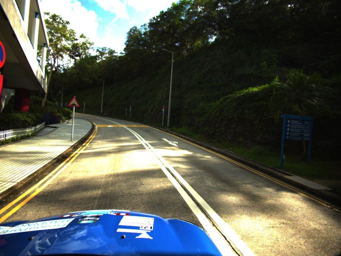

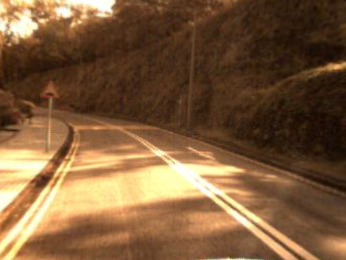

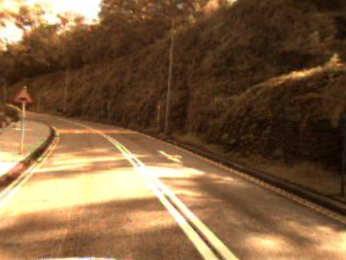

In [56]:
# TEST: visualize data
from PIL import Image
from IPython.display import display
import open3d

frame_id = 1000

# Visualize data
pcd_path = os.path.join(kitti_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

pcd_path = os.path.join(kitti_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

img_path = os.path.join(kitti_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
display(img_resize)

img_path = os.path.join(kitti_path, 'vehicle_frame_cam01', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
display(img_resize)

img_path = os.path.join(kitti_path, 'event_cam00', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)

img_path = os.path.join(kitti_path, 'event_cam01', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)